<a href="https://colab.research.google.com/github/egor501123/Test-case/blob/main/PD_jun_ds_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, PowerTransformer,
                                  LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif, chi2
from xgboost import XGBClassifier

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, BorderlineSMOTE, KMeansSMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn import set_config
set_config(display='diagram') 

# Домашнее задание для Junior DS по разработке PD модели

# Новый раздел

<b>Задание:</b> Необходиом разработать модель предсказания дефолта. Даны финансовые данные 32 395 компаний (выручка, активы, пассивы и т.д). Результат будет оцениваться на скрытой выборке из 200 компаний по метрике качества accuracy_score

<b>Цель задания</b> научиться / показать знания в разработке моделей оценки риска - probability of default. Задание приближено к реальному, данные синтетические. Лидерборд для оценки собственного решения и геймификации процесса обучения. Первое место в лидерборде не явлется целью. Цель - правильно разарботанная модель, удовлетворяющая требованиям банковской системы. В случае возникновения вопросов, сотрудники блока Риски готовы проконсультировать и дать обратную связь на модель (телеграм чат).

<b>Метрика качества</b> accuracy_score вычисляется, как ( True positive + True negative ) / Total. Если сабмит-файл, не правильного формата или неверное количество строк, метрика будет = 0.

In [ ]:
train_df = pd.read_csv('PD-data-train.csv', sep=';')
test_df = pd.read_csv('PD-data-test.csv', sep=';')

Описание данных

Семплы и размеры выборок

In [ ]:
print(train_df.shape)
train_df.head()

(32395, 37)


,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,...,adr_actual_age,head_actual_age,cap_actual_age,ul_staff_range,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
0,7,52996000.0,48344000.0,48344000.0,0.0,0.0,4652000.0,-2608000.0,2044000.0,846000.0,...,3,3,3,[1-100],50000.0,2,0,0,0,0
1,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12,12,12,[1-100],10000.0,5,0,0,0,0
2,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,28,28,28,[1-100],10000.0,2,0,0,0,0
3,22,32049000.0,29568000.0,29568000.0,0.0,0.0,2481000.0,-260000.0,2221000.0,302000.0,...,8,8,8,[1-100],300000.0,1,0,0,0,0
4,23,16458000.0,14935000.0,14935000.0,0.0,0.0,1523000.0,-274000.0,1249000.0,538000.0,...,27,27,27,[1-100],10000.0,2,0,0,0,0


In [ ]:
#new_df = train_df.dropna()
new_df = train_df.drop_duplicates(keep='first')
uniq_num_features = new_df.drop(columns =['record_id','ul_staff_range'])
uniq_num_features.shape

(32395, 35)

In [ ]:
new_df.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

,record_id,ar_revenue,ar_total_expenses,ar_sale_cost,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_profit_before_tax,ar_taxes,ar_other_profit_and_losses,ar_net_profit,ab_immobilized_assets,ab_mobile_current_assets,ab_inventory,ab_accounts_receivable,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_own_capital,ab_borrowed_capital,ab_long_term_liabilities,ab_short_term_borrowing,ab_accounts_payable,ab_other_borrowings,bus_age,ogrn_age,adr_actual_age,head_actual_age,cap_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
record_id,1.00,0.01,0.01,0.01,0.00,0.00,-0.00,0.00,-0.00,-0.00,0.00,-0.00,0.01,-0.00,-0.00,-0.00,-0.01,-0.00,0.01,0.01,-0.00,-0.01,-0.00,0.01,-0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.01,0.00,0.00,nan,-0.00
ar_revenue,0.01,1.00,0.99,0.98,0.47,0.23,0.31,-0.19,0.26,0.43,0.10,0.23,0.27,0.61,0.46,0.52,0.20,0.16,0.38,0.37,0.55,0.13,0.44,0.58,0.05,0.16,0.17,-0.03,-0.03,-0.03,0.11,0.06,0.10,0.05,nan,-0.06
ar_total_expenses,0.01,0.99,1.00,0.99,0.48,0.24,0.17,-0.17,0.12,0.39,0.10,0.09,0.25,0.59,0.44,0.50,0.20,0.15,0.32,0.34,0.53,0.12,0.43,0.57,0.05,0.15,0.16,-0.03,-0.03,-0.03,0.11,0.06,0.10,0.05,nan,-0.06
ar_sale_cost,0.01,0.98,0.99,1.00,0.39,0.18,0.18,-0.17,0.12,0.39,0.09,0.10,0.24,0.58,0.43,0.50,0.18,0.13,0.32,0.34,0.52,0.12,0.42,0.56,0.04,0.14,0.16,-0.03,-0.03,-0.03,0.10,0.06,0.09,0.05,nan,-0.06
ar_selling_expenses,0.00,0.47,0.48,0.39,1.00,0.06,0.06,-0.04,0.05,0.13,0.11,0.04,0.14,0.27,0.23,0.18,0.21,0.05,0.10,0.12,0.28,0.07,0.23,0.30,-0.01,0.08,0.07,-0.03,-0.03,-0.03,0.03,0.07,0.12,-0.00,nan,-0.02
ar_management_expenses,0.00,0.23,0.24,0.18,0.06,1.00,-0.04,-0.11,-0.08,0.19,0.03,-0.09,0.18,0.16,0.09,0.15,0.10,0.32,0.12,0.15,0.22,0.05,0.09,0.18,0.21,0.08,0.06,-0.01,-0.01,-0.01,0.11,0.03,0.06,-0.00,nan,-0.01
ar_sale_profit,-0.00,0.31,0.17,0.18,0.06,-0.04,1.00,-0.16,0.95,0.33,0.07,0.94,0.19,0.30,0.23,0.25,0.10,0.12,0.47,0.30,0.22,0.10,0.15,0.20,0.05,0.10,0.10,-0.02,-0.02,-0.02,0.05,0.02,0.03,0.01,nan,-0.03
ar_balance_of_rvns_and_expns,0.00,-0.19,-0.17,-0.17,-0.04,-0.11,-0.16,1.00,0.15,-0.15,-0.01,0.16,0.05,-0.21,-0.04,-0.29,-0.09,-0.07,0.15,0.06,-0.22,-0.09,-0.14,-0.19,-0.07,0.02,-0.03,-0.01,-0.01,-0.01,-0.02,0.05,-0.02,-0.02,nan,0.01
ar_profit_before_tax,-0.00,0.26,0.12,0.12,0.05,-0.08,0.95,0.15,1.00,0.29,0.07,1.00,0.21,0.24,0.22,0.16,0.07,0.10,0.51,0.32,0.16,0.07,0.11,0.14,0.03,0.10,0.09,-0.02,-0.02,-0.02,0.04,0.03,0.03,0.01,nan,-0.03
ar_taxes,-0.00,0.43,0.39,0.39,0.13,0.19,0.33,-0.15,0.29,1.00,0.05,0.21,0.12,0.28,0.18,0.27,0.08,0.12,0.53,0.28,0.19,0.02,0.12,0.23,0.03,0.10,0.10,-0.02,-0.02,-0.02,0.01,0.00,0.05,0.04,nan,-0.04


In [ ]:
from sklearn.feature_selection import VarianceThreshold
constant_filter = VarianceThreshold(threshold=0.2)
constant_filter.fit(uniq_num_features)
constant_columns = [column for column in uniq_num_features.columns if column not in uniq_num_features.columns[constant_filter.get_support()]] 
uniq_num_features.drop(columns = constant_columns )
correlated_features = set()
correlation_matrix = uniq_num_features.corr()
for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.65:
            colname = correlation_matrix.columns[i] 
            correlated_features.add(colname)
len(correlated_features)
num = uniq_num_features.drop(columns=correlated_features)



In [ ]:
num.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,ar_revenue,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_taxes,ar_other_profit_and_losses,ab_immobilized_assets,ab_mobile_current_assets,ab_other_current_assets,ab_cash_and_securities,ab_losses,ab_long_term_liabilities,ab_short_term_borrowing,ab_other_borrowings,bus_age,adr_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,ul_systematizing_flg,default_12m
ar_revenue,1.00,0.47,0.23,0.31,-0.19,0.43,0.10,0.27,0.61,0.20,0.16,0.38,0.13,0.44,0.05,0.16,-0.03,0.11,0.06,0.10,0.05,nan,-0.06
ar_selling_expenses,0.47,1.00,0.06,0.06,-0.04,0.13,0.11,0.14,0.27,0.21,0.05,0.10,0.07,0.23,-0.01,0.08,-0.03,0.03,0.07,0.12,-0.00,nan,-0.02
ar_management_expenses,0.23,0.06,1.00,-0.04,-0.11,0.19,0.03,0.18,0.16,0.10,0.32,0.12,0.05,0.09,0.21,0.08,-0.01,0.11,0.03,0.06,-0.00,nan,-0.01
ar_sale_profit,0.31,0.06,-0.04,1.00,-0.16,0.33,0.07,0.19,0.30,0.10,0.12,0.47,0.10,0.15,0.05,0.10,-0.02,0.05,0.02,0.03,0.01,nan,-0.03
ar_balance_of_rvns_and_expns,-0.19,-0.04,-0.11,-0.16,1.00,-0.15,-0.01,0.05,-0.21,-0.09,-0.07,0.15,-0.09,-0.14,-0.07,0.02,-0.01,-0.02,0.05,-0.02,-0.02,nan,0.01
ar_taxes,0.43,0.13,0.19,0.33,-0.15,1.00,0.05,0.12,0.28,0.08,0.12,0.53,0.02,0.12,0.03,0.10,-0.02,0.01,0.00,0.05,0.04,nan,-0.04
ar_other_profit_and_losses,0.10,0.11,0.03,0.07,-0.01,0.05,1.00,0.14,0.08,0.03,0.03,0.09,0.05,0.05,0.00,0.06,-0.01,0.03,0.05,0.05,0.01,nan,-0.01
ab_immobilized_assets,0.27,0.14,0.18,0.19,0.05,0.12,0.14,1.00,0.35,0.21,0.09,0.35,0.39,0.21,0.15,0.24,-0.05,0.33,0.20,0.02,0.09,nan,-0.03
ab_mobile_current_assets,0.61,0.27,0.16,0.30,-0.21,0.28,0.08,0.35,1.00,0.35,0.13,0.37,0.48,0.51,0.14,0.15,-0.05,0.17,0.07,0.05,0.02,nan,-0.04
ab_other_current_assets,0.20,0.21,0.10,0.10,-0.09,0.08,0.03,0.21,0.35,1.00,0.04,0.10,0.25,0.22,0.03,0.04,-0.04,0.18,0.00,0.02,0.00,nan,-0.01


In [ ]:
num_features = num.drop(columns = 'ul_systematizing_flg')

In [ ]:
num_features.head()

,ar_revenue,ar_selling_expenses,ar_management_expenses,ar_sale_profit,ar_balance_of_rvns_and_expns,ar_taxes,ar_other_profit_and_losses,ab_immobilized_assets,ab_mobile_current_assets,ab_other_current_assets,...,ab_long_term_liabilities,ab_short_term_borrowing,ab_other_borrowings,bus_age,adr_actual_age,ul_capital_sum,ul_founders_cnt,ul_branch_cnt,ul_strategic_flg,default_12m
0,52996000.0,0.0,0.0,4652000.0,-2608000.0,846000.0,0.0,0.0,7240000.0,0.0,...,0.0,11349000.0,0.0,198,3,50000.0,2,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,256,12,10000.0,5,0,0,0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,33,28,10000.0,2,0,0,0
3,32049000.0,0.0,0.0,2481000.0,-260000.0,302000.0,0.0,0.0,4245000.0,0.0,...,0.0,3652000.0,0.0,185,8,300000.0,1,0,0,0
4,16458000.0,0.0,0.0,1523000.0,-274000.0,538000.0,0.0,0.0,8950000.0,0.0,...,0.0,0.0,0.0,220,27,10000.0,2,0,0,0


In [ ]:
num_features.shape

(32395, 22)

In [ ]:
qconstant_filter = VarianceThreshold(threshold=0.2 )
qconstant_filter.fit(num_features)
qconstant_columns = [column for column in num_features.columns if column not in num_features.columns[qconstant_filter.get_support()]]
print((qconstant_columns))
num_features = num.drop(columns = qconstant_columns)
num_features.shape

['ul_branch_cnt', 'ul_strategic_flg', 'default_12m']


(32395, 20)

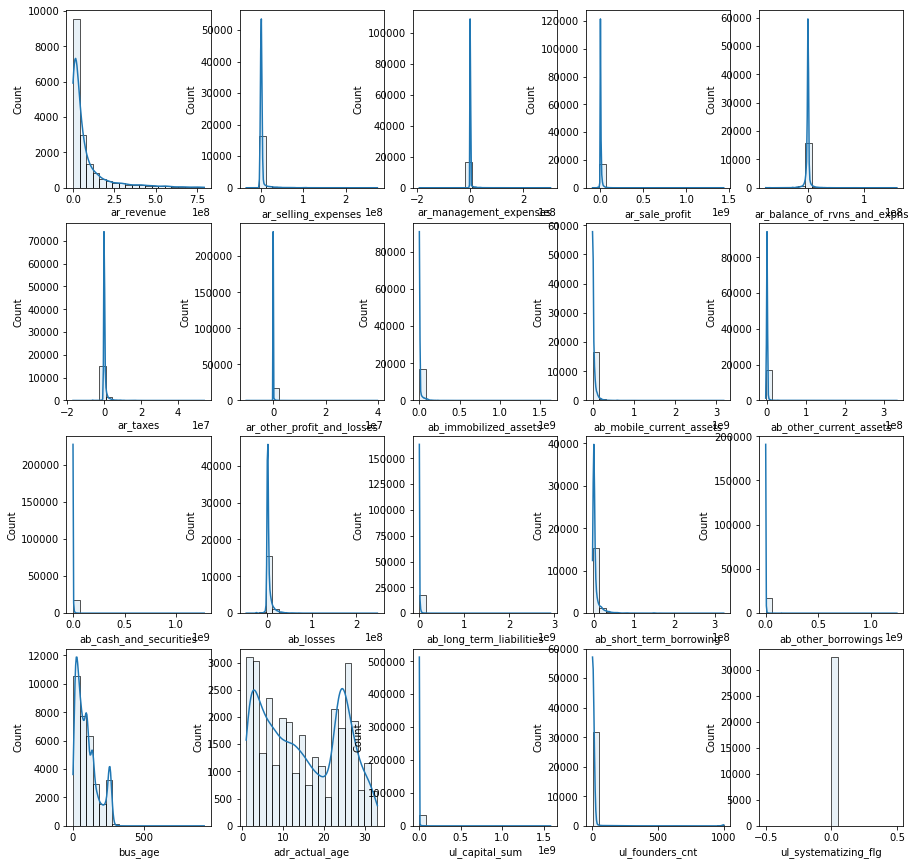

In [ ]:
import numpy as np 
fig, ax = plt.subplots(4,5, figsize=(15,15))
ax = np.ravel(ax)
for name, axi in zip(num_features.columns, ax):
    sns.histplot(num_features[name],kde=True, bins=20, ax=axi, label=name, alpha=0.1)




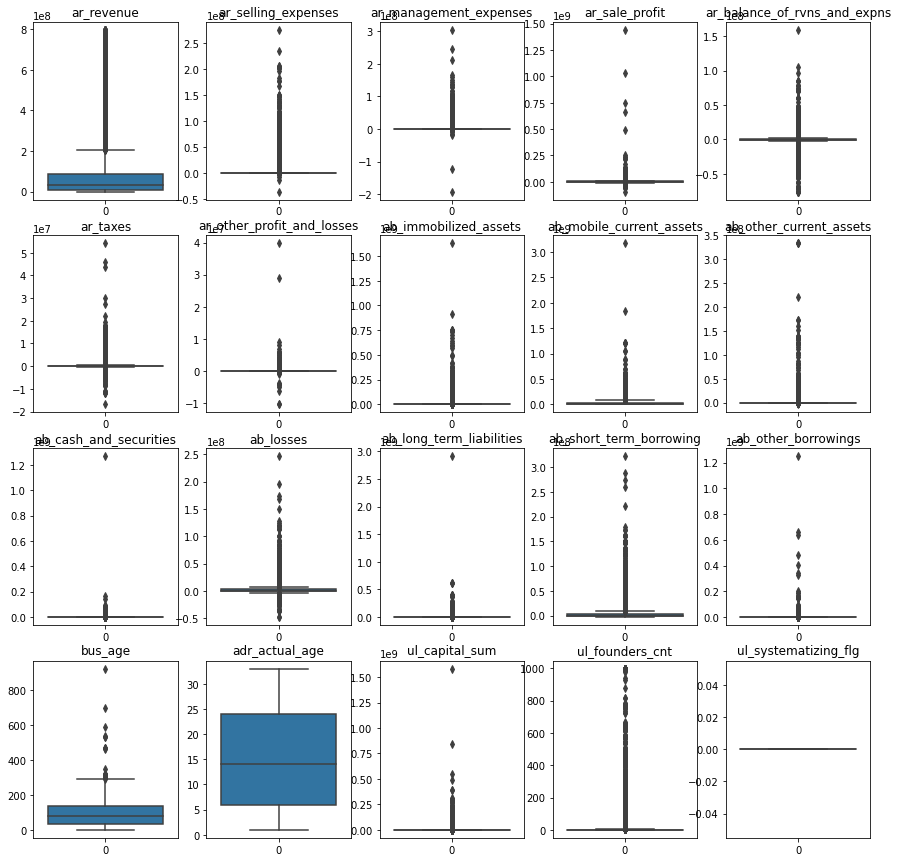

In [ ]:
fig,ax = plt.subplots(4,5,figsize=(15,15))
ax = np.ravel(ax)
for name, axi in zip(num_features.columns, ax):
  sns.boxplot(data=num_features[name], ax=axi)
  axi.title.set_text(name)


Видно что много распределений похожих на дельда функцию, дабы не перегружать модель из-за большой матрицы объект признак, можно попробовать просто удалить признаки с дельтаподобными распределениями. Так резво выкидываю фичи, т.к. очень большая тренировочная выборка и, вероятнее всего, мой ноут не сможет считать модели за разумное время.


In [ ]:
columns = ['ar_revenue', 'ar_sale_profit',
           'ar_balance_of_rvns_and_expns',
           'ar_taxes','ab_mobile_current_assets',
           'ar_other_profit_and_losses','bus_age',
           'adr_actual_age','ul_capital_sum',
           'ul_founders_cnt']
numerical_features = numerical_features[columns]
numerical_features.shape




(32395, 10)

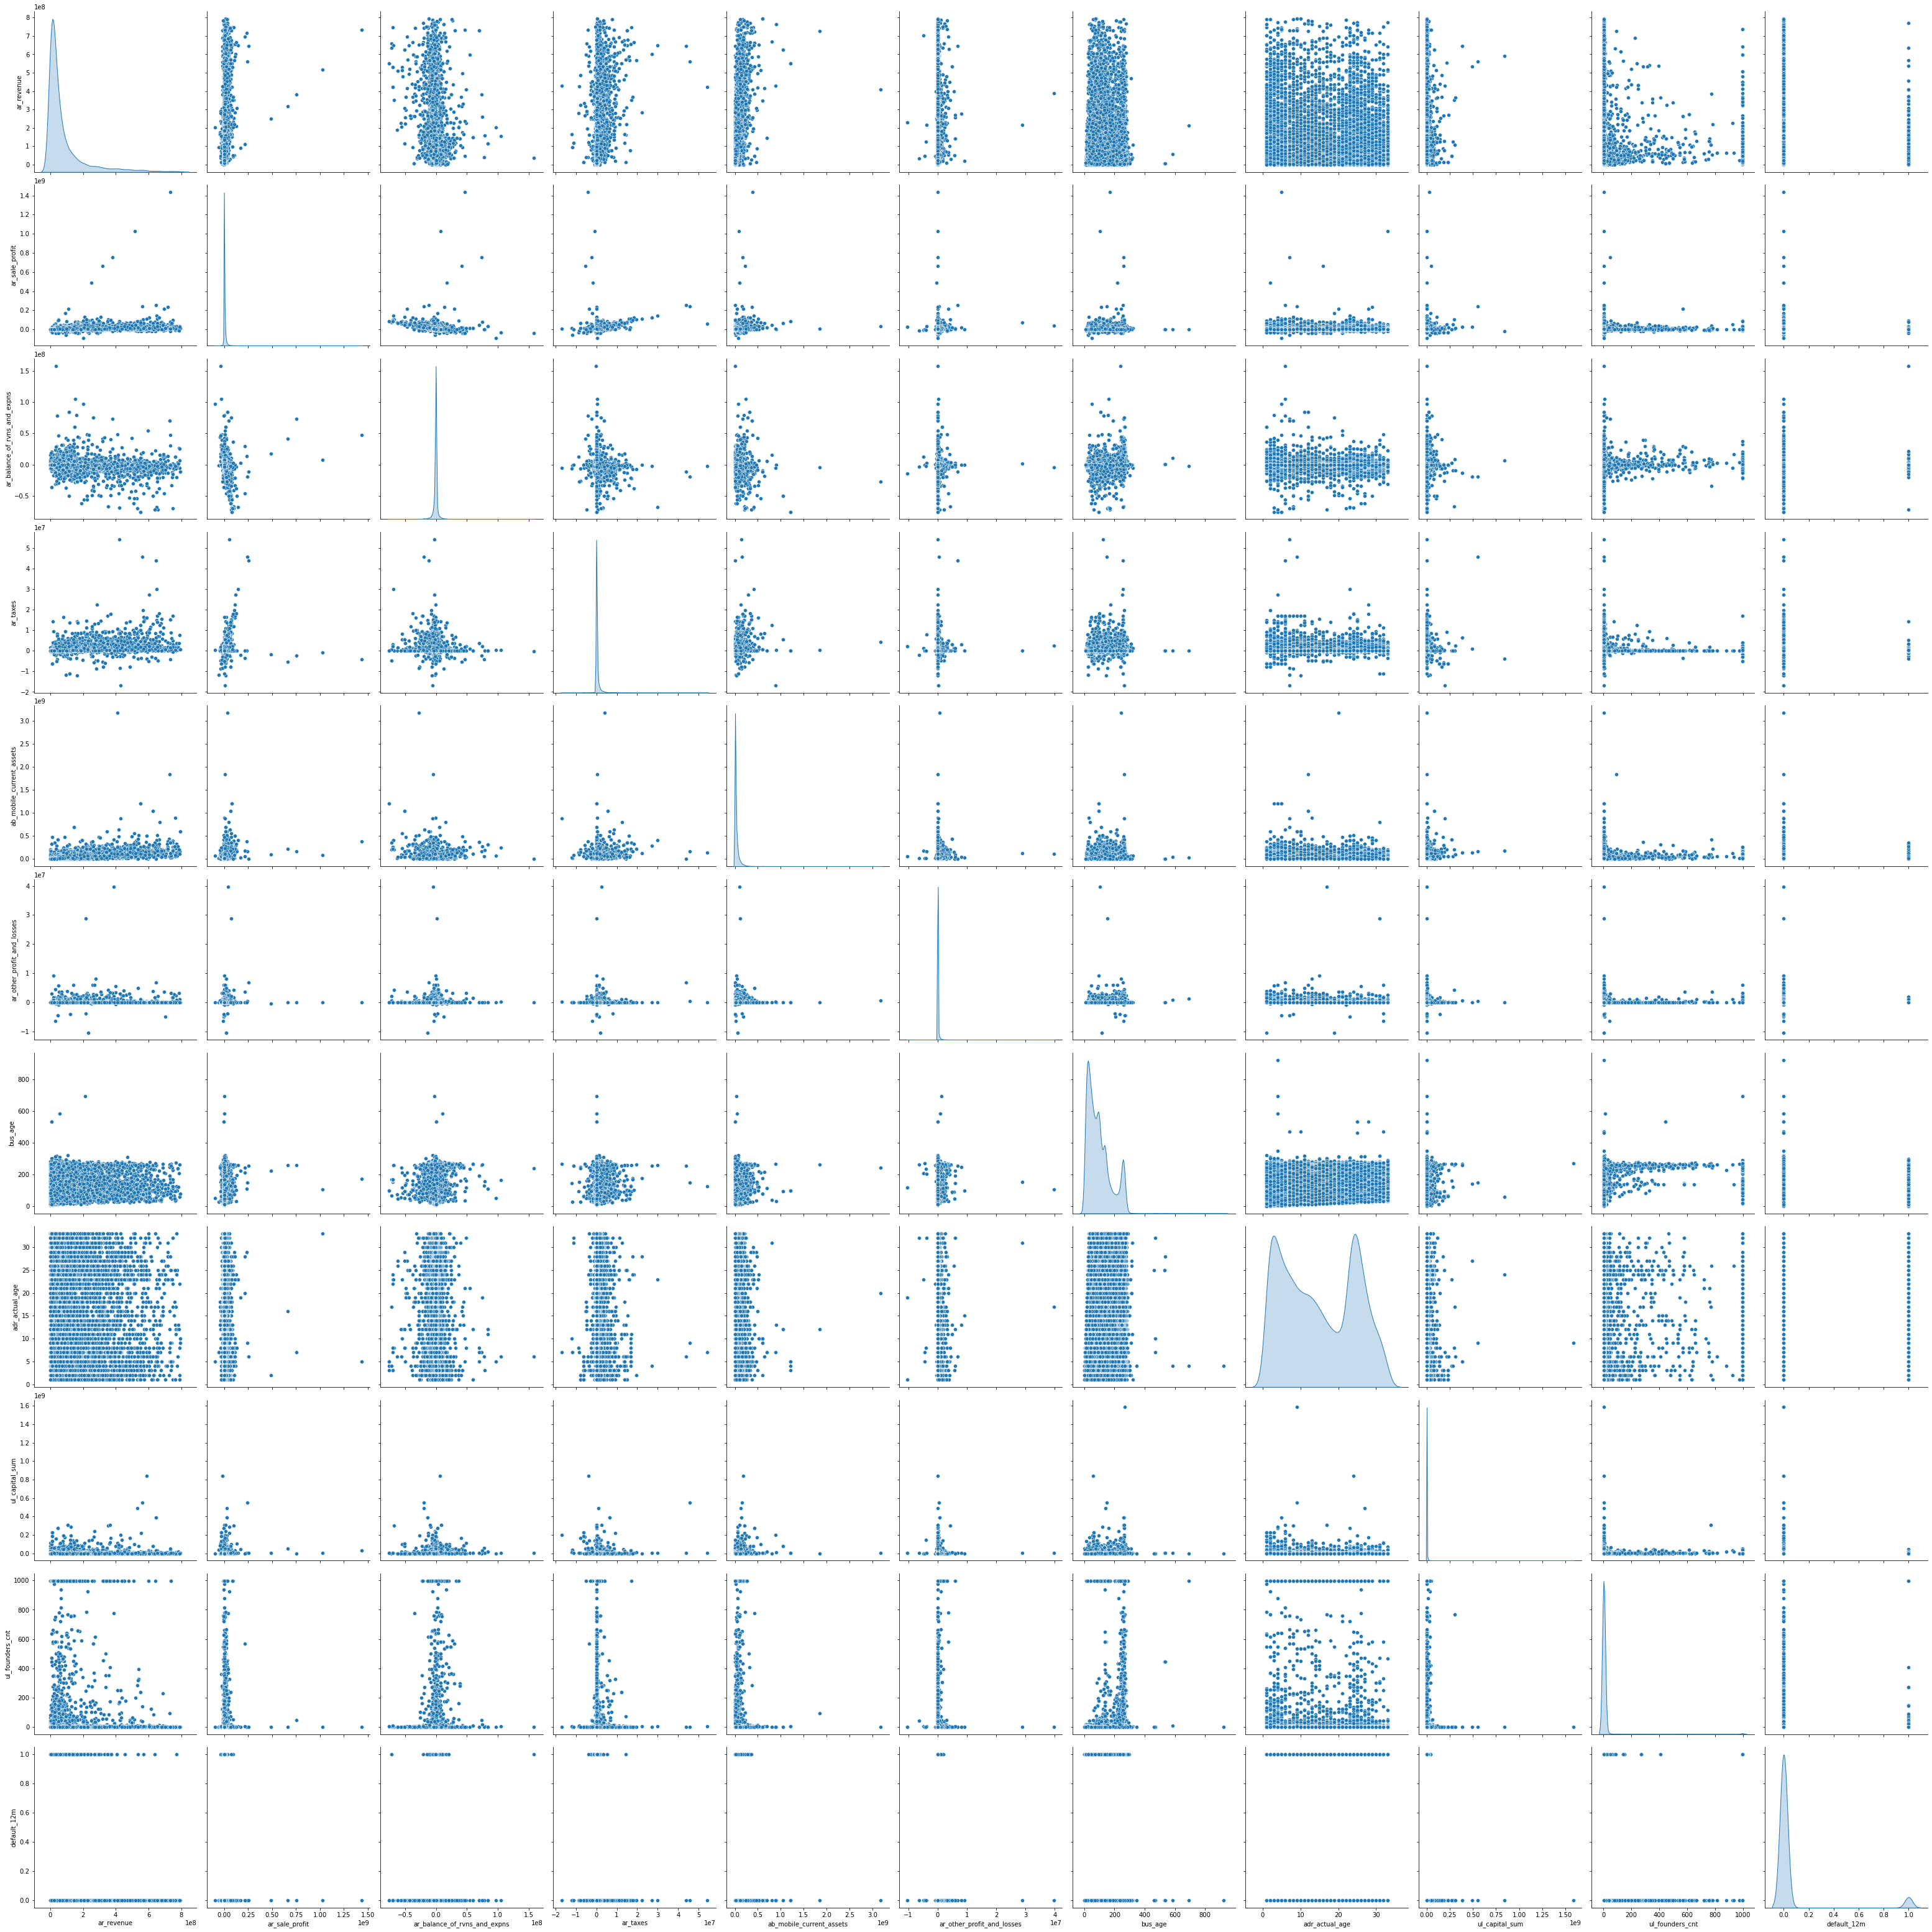

In [ ]:
names = ['ar_revenue', 'ar_sale_profit',
           'ar_balance_of_rvns_and_expns',
           'ar_taxes','ab_mobile_current_assets',
           'ar_other_profit_and_losses','bus_age',
           'adr_actual_age','ul_capital_sum',
           'ul_founders_cnt','default_12m']
sns.pairplot(new_df[names], diag_kind='kde', height=4);

Разбиение по классам у нас не сбалансированное, что стоит отметить и будет применяться в дальнейшем



In [ ]:
# Функция для удобного представления оценок моделей
def model_score(model, X_test, y_test):
    name = ''
    scores = {}
    scores['accuracy'] = accuracy_score(y_test, model.predict(X_test))
    if str(model).split('(')[0] == 'StackingClassifier':
        name = 'StackingClassifier'
    else:
        name = str(model.get_params()['steps'][-1][1]).split('(')[0]
    return pd.DataFrame(scores, index=[name])

In [ ]:
RANDOM_STATE = 42

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
numerical_features['ul_staff_range'] = train_df['ul_staff_range'].astype('category')
X = numerical_features 
y = new_df['default_12m']

# Разделим выборку на тренировочную и тестовую части.
# Т.к. выборка несбалансирована, будем использовать стратификацию по y.
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)


num_features = columns
cat_features = ['ul_staff_range']


# Создадим сплиттер для кросс-валидации при подборе гиперпараметров и для стэкинга.
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [ ]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_zero = SimpleImputer(missing_values=np.nan,strategy='constant', fill_value=0)
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
ttt = OrdinalEncoder()
imp_zero.fit_transform(X_train)
ttt.fit_transform(X_train['ul_staff_range'].values.reshape(-1,1))


array([[2.],
       [2.],
       [2.],
       ...,
       [0.],
       [2.],
       [2.]])

In [ ]:
# Создадим пайплан препроцессинга.
# Обработка числовых признаков.
from sklearn.decomposition import PCA # Не успел протестить использование метода главных компонен, при обучении на всех данных, 
# без удаления пропусков 

num_prep = Pipeline([
                    ('inputer',SimpleImputer(missing_values=np.nan, strategy='mean')),
                    ('scale', StandardScaler()),
                    
                    ])


# Обработка категориальных признаков
cat_prep = Pipeline([
                    ('encoding', OrdinalEncoder()),
                    ('inputer',SimpleImputer(strategy='constant', fill_value=0))
                    ])
# Собираем препроцессинг вместе
preprocessing = ColumnTransformer([
                         ('num', num_prep,num_features),
                         ('cat', cat_prep, cat_features)
])


full_preprocessing = FeatureUnion([
                                 ('prep', preprocessing)
])



In [ ]:
# Создадим полные пайплайны для всех моделей.
# Лог регрессия
lr_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', LogisticRegression(random_state=RANDOM_STATE, max_iter=200,
                                                       class_weight='balanced', n_jobs=-1))
                        ])

# К-ближайших соседей
knn_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', KNeighborsClassifier(n_jobs=-1))
                        ])

# Решающие деревья
dtc_pipe = imbPipeline([
                        ('prep_and_fe', full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'))
                        ])

# Случайный лес
rfc_pipe = imbPipeline([
                        ('prep_and_fe',full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, class_weight='balanced'))
                        ])


# Байесовский классификатор
nb_pipe = test_pipe = imbPipeline([
                        ('prep_and_fe',full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', GaussianNB())
                        ])

# Градиентный бустинг
xgb_pipe = imbPipeline([
                        ('prep_and_fe',full_preprocessing),
                        ('sampling', SMOTE()),
                        ('select', SelectKBest(score_func=mutual_info_classif)),
                        ('reduce_dim', PCA(.95)),
                        ('classif', XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1))
                        ])

In [ ]:
k_list = list(np.arange(1,11))
k_list.append('all')
len(k_list)


11

In [ ]:
# Создаём словарь для подбора вариантов препроцессинга.
prep_params = {
      'prep_and_fe__prep__num__scale': [StandardScaler(), PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder(), OneHotEncoder(drop='if_binary')],
      'select__k': k_list,
      'sampling': ['drop',SMOTE(random_state=RANDOM_STATE), ADASYN(random_state=RANDOM_STATE),
                 SMOTEENN(random_state=RANDOM_STATE)],     
}

# Логистическая регрессия
prep_lr_gs = GridSearchCV(estimator=lr_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# К-ближайших соседей
prep_knn_gs = GridSearchCV(estimator=knn_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# Решающие деревья
prep_dtc_gs = GridSearchCV(estimator=dtc_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

#Random forest
prep_rfc_gs = GridSearchCV(estimator=rfc_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)


# Байесовский классификатор
# Тут параметры только для препроцессинга подбираем.
prep_nb_gs = GridSearchCV(estimator=nb_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# Градиентный бустинг
prep_xgb_gs = GridSearchCV(estimator=xgb_pipe, param_grid=prep_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

In [ ]:
%%time
# Подбираем лучшие варианты препроцессинга для каждой модели.
# Список наших gridsearch-моделей.
prep_gs_list = [prep_lr_gs, prep_knn_gs, prep_dtc_gs, prep_rfc_gs, prep_nb_gs, prep_xgb_gs]
for model in prep_gs_list:
    model.fit(X_train, y_train)
    
    

Fitting 5 folds for each of 176 candidates, totalling 880 fits
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Fitting 5 folds for each of 176 candidates, totalling 880 fits
Fitting 5 folds for each of 176 candidates, totalling 880 fits
CPU times: total: 1min 49s
Wall time: 2h 5min 41s


In [ ]:
# Отобразим лучшие параметры препроцессинга для каждой модели.
names_list = ['Logistic Regression','K-neighbors classifier', 'Decision tree classifier',
              'Random forest classifier','Naive Bayes', 'XGBoost']
for name, model in zip(names_list,prep_gs_list):
    print(f'\nBest preprocessing for {name}')
    print(pd.Series(model.best_params_))


Best preprocessing for Logistic Regression
prep_and_fe__prep__cat__encoding    OneHotEncoder(drop='if_binary')
prep_and_fe__prep__num__scale                    PowerTransformer()
sampling                                     SMOTE(random_state=42)
select__k                                                         2
dtype: object

Best preprocessing for K-neighbors classifier
prep_and_fe__prep__cat__encoding           OrdinalEncoder()
prep_and_fe__prep__num__scale              StandardScaler()
sampling                            ADASYN(random_state=42)
select__k                                                 1
dtype: object

Best preprocessing for Decision tree classifier
prep_and_fe__prep__cat__encoding             OrdinalEncoder()
prep_and_fe__prep__num__scale              PowerTransformer()
sampling                            SMOTEENN(random_state=42)
select__k                                                   1
dtype: object

Best preprocessing for Random forest classifier
prep_and_

In [ ]:
# Логистическая регрессия
full_lr_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder()],
      'select__k': [3],
      'sampling': [ SMOTEENN(random_state=RANDOM_STATE)],
      'classif__penalty': ['l1','l2','elasticnet'],
      'classif__C': np.arange(0.1,1.1,0.1),
      'classif__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],      
}

gslr = GridSearchCV(estimator=lr_pipe, param_grid=full_lr_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# К-ближайших соседей
full_knn_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder()],
      'select__k': [1],
      'sampling': [ ADASYN(random_state=RANDOM_STATE)],
      'classif__n_neighbors': np.arange(2,10),
      'classif__algorithm': ['ball_tree', 'kd_tree', 'brute'],
      'classif__weights': ['uniform','distance'],      
}

gsknn = GridSearchCV(estimator=knn_pipe, param_grid=full_knn_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# Решающие деревья
full_dtc_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OneHotEncoder(drop='if_binary')],
      'select__k': [1],
      'sampling': [ SMOTEENN(random_state=RANDOM_STATE)],
      'classif__criterion': ['gini','entropy'],
      'classif__splitter': ['best', 'random'],
      'classif__max_features': ['sqrt', 'log2'],
      'classif__min_samples_leaf': np.arange(1,200,10),

}

gsdtc = GridSearchCV(estimator=dtc_pipe, param_grid=full_dtc_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# Случайный лес
full_rfc_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder()],
      'select__k': [1],
      'sampling': [ADASYN(random_state=RANDOM_STATE)],
      'classif__n_estimators': np.arange(100,301,50),
      'classif__criterion': ['gini', 'entropy'],
      'classif__max_features': ['sqrt', 'log2'],
      'classif__min_samples_leaf': np.arange(1,200,10),

}

gsrfc = GridSearchCV(estimator=rfc_pipe, param_grid=full_rfc_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

#Баесовский классификатор
full_nb_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder()],
      'select__k': [1],
      'sampling': [SMOTE(random_state=RANDOM_STATE)]
}

gsnb = GridSearchCV(estimator=nb_pipe, param_grid=full_nb_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

# Градиентный бустинг
full_xgb_params = {
      'prep_and_fe__prep__num__scale': [PowerTransformer(method='yeo-johnson')],
      'prep_and_fe__prep__cat__encoding': [OrdinalEncoder()],
      'select__k': [1],
      'sampling': [SMOTEENN(random_state=RANDOM_STATE)],
      'classif__n_estimators': np.arange(50,401,50),
      'classif__learning_rate': [0.001,0.01, 0.1, 0.2, 0.3]
}

gsxgb = GridSearchCV(estimator=xgb_pipe, param_grid=full_xgb_params, scoring='accuracy', cv=skf, n_jobs=-1, verbose=3)

In [ ]:
%%time
#Выведем лучшие параметры для моделей
full_gs_list = [gslr, gsknn, gsdtc, gsrfc, gsnb, gsxgb] 
names_list = ['Logistic Regression','K-neighbors classifier', 'Decision tree classifier',
              'Random forest classifier','Naive Bayes', 'XGBoost'] 
for name, model in zip(names_list,full_gs_list):
    model.fit(X_train, y_train)
    print(f'\nBest params for {name}')
    print(pd.Series(model.best_params_))

Fitting 5 folds for each of 150 candidates, totalling 750 fits

Best params for Logistic Regression
classif__C                                                0.1
classif__penalty                                           l1
classif__solver                                          saga
prep_and_fe__prep__cat__encoding             OrdinalEncoder()
prep_and_fe__prep__num__scale              PowerTransformer()
sampling                            SMOTEENN(random_state=42)
select__k                                                   3
dtype: object
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best params for K-neighbors classifier
classif__algorithm                                ball_tree
classif__n_neighbors                                      4
classif__weights                                    uniform
prep_and_fe__prep__cat__encoding           OrdinalEncoder()
prep_and_fe__prep__num__scale            PowerTransformer()
sampling                            ADASYN(random_

In [ ]:
# Итоговые параметры для каждой модели
# Логистическая регрессия
final_lr_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OrdinalEncoder(),
      'select__k': 3,
      'sampling':  SMOTEENN(random_state=RANDOM_STATE),
      'classif__penalty': 'l1',
      'classif__C': 0.1,
      'classif__solver': 'saga',      
}

# К-ближайших соседей
final_knn_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OrdinalEncoder(),
      'select__k': 1,
      'sampling':  ADASYN(random_state=RANDOM_STATE),
      'classif__n_neighbors': 4,
      'classif__algorithm': 'ball_tree',
      'classif__weights': 'uniform',      
}

# Решающие деревья
final_dtc_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OneHotEncoder(drop='if_binary'),
      'select__k': 1,
      'sampling':  SMOTEENN(random_state=RANDOM_STATE),
      'classif__criterion': 'gini',
      'classif__splitter': 'best',
      'classif__max_features': 'sqrt',
      'classif__min_samples_leaf': 1,

}

# Случайный лес
final_rfc_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OrdinalEncoder(),
      'select__k': 1,
      'sampling': ADASYN(random_state=RANDOM_STATE),
      'classif__n_estimators': 100,
      'classif__criterion': 'gini',
      'classif__max_features': 'sqrt',
      'classif__min_samples_leaf': 1,

}



# Байесовский классификатор
final_nb_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OrdinalEncoder(),
      'select__k': 8,
      'sampling': SMOTEENN(random_state=RANDOM_STATE)
}


# Градиентный бустинг
final_xgb_params = {
      'prep_and_fe__prep__num__scale': PowerTransformer(method='yeo-johnson'),
      'prep_and_fe__prep__cat__encoding': OrdinalEncoder(),
      'select__k': 1,
      'sampling': SMOTEENN(random_state=RANDOM_STATE),
      'classif__n_estimators': 250,
      'classif__learning_rate': 0.3
}

In [ ]:
final_lr = lr_pipe.set_params(**final_lr_params)
final_knn = knn_pipe.set_params(**final_knn_params)
final_dtc = dtc_pipe.set_params(**final_dtc_params)
final_rfc = rfc_pipe.set_params(**final_rfc_params)
final_nb = nb_pipe.set_params(**final_nb_params)
final_xgb = xgb_pipe.set_params(**final_xgb_params)

In [ ]:
##Сделаем стекинг моделек
stacking_list = [('lr',final_lr), ('knn',final_knn), ('dtc',final_dtc),
                  ('rfc',final_rfc), #('nb', final_nb),
                  ('xgb', final_xgb)]
final_stacking = StackingClassifier(estimators=stacking_list,
                                    final_estimator = LogisticRegression(random_state=RANDOM_STATE),
                                    cv=skf, n_jobs=-1)


In [ ]:
final_stacking.fit(X_train, y_train)


StackingClassifier(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimators=[('lr',
                                Pipeline(steps=[('prep_and_fe',
                                                 FeatureUnion(transformer_list=[('prep',
                                                                                 ColumnTransformer(transformers=[('num',
                                                                                                                  Pipeline(steps=[('scale',
                                                                                                                                   PowerTransformer()),
                                                                                                                                  ('inputer',
                                                                                                                                   SimpleImputer(fill_value=0,
                                                                                                                                                 strategy='constant'))]),
                                                                                                                  ['ar_revenue',
                                                                                                                   'ar_sale_profit',
                                                                                                                   'ar_ba...
                                                               importance_type=None,
                                                               interaction_constraints='',
                                                               learning_rate=0.3,
                                                               max_bin=256,
                                                               max_cat_threshold=64,
                                                               max_cat_to_onehot=4,
                                                               max_delta_step=0,
                                                               max_depth=6,
                                                               max_leaves=0,
                                                               min_child_weight=1,
                                                               missing=nan,
                                                               monotone_constraints='()',
                                                               n_estimators=250,
                                                               n_jobs=-1,
                                                               num_parallel_tree=1,
                                                               predictor='auto',
                                                               random_state=42, ...))]))],
                   final_estimator=LogisticRegression(random_state=42),
                   n_jobs=-1)

In [ ]:
scoring_list = [final_lr, final_knn, final_dtc, final_rfc, final_nb, final_xgb,final_stacking]
final_scores = pd.DataFrame()
for model in scoring_list:
    model.fit(X_train,y_train)
    final_scores = final_scores.append(model_score(model, X_test, y_test))
    

,accuracy
LogisticRegression,0.576165
KNeighborsClassifier,0.953860
DecisionTreeClassifier,0.953629
RandomForestClassifier,0.953860
GaussianNB,0.295618
XGBClassifier,0.933921
StackingClassifier,0.953860


In [ ]:
final_scores.sort_values(by=['accuracy'])

,accuracy
GaussianNB,0.295618
LogisticRegression,0.576165
XGBClassifier,0.933921
DecisionTreeClassifier,0.953629
KNeighborsClassifier,0.953860
RandomForestClassifier,0.953860
StackingClassifier,0.953860


### Формирование файла с ответом

In [ ]:
answ_df = test_df[['record_id']]


In [ ]:
answ_df['id'] = answ_df['record_id']

In [ ]:
answ_df.drop('record_id',axis=1, inplace=True)

In [ ]:
cutoff = y_train.mean()


In [ ]:
names = ['ar_revenue', 'ar_sale_profit',
           'ar_balance_of_rvns_and_expns',
           'ar_taxes','ab_mobile_current_assets',
           'ar_other_profit_and_losses','bus_age',
           'adr_actual_age','ul_capital_sum',
           'ul_founders_cnt'
           ]
new_test_df = test_df[names]
categ_test = test_df['ul_staff_range'].astype('category')
new_test_df['ul_staff_range'] = categ_test  
X1 = new_test_df
X1.shape

(200, 11)

In [ ]:
answ_df['predict'] = (final_rfc.predict_proba(X1)[:,1]>cutoff).astype(int)

In [ ]:
answ_df.to_csv('PD-submit7.csv',index=False, sep=';')


Финальный скор
![image.png](attachment:image.png)

Для загрузки своего рузультата на https://dsbattle.com/hackathons/juniords-new/ вам нужно создать csv файл с двумя колонками (id, predict), разделитель - точка с запятой (;)